Toute fonction peut être vue comme une somme infinie d'impulsion de Dirac: $$x(t) = \int_{-\infty}^{\infty} x(\tau) \delta(t-\tau) d\tau$$

Si on connaît la réponse d'un système LTI (Linear and Time Invariant) à une impulsion de Dirac: $$\delta(t) \rightarrow h(t)$$
on peut calculer par linéarité la réponse au signal $f(t)$ quelconque: $$y(t) = \int_{-\infty}^{\infty} x(\tau) h(t-\tau) d\tau = x(t) * h(t)$$
Cette intégrale est appelée produit de convolution de $f$ et $h$et est noté $*$.

C'est ici qu'il est intéressant de passer dans le domaine de Laplace car les produits de convolution deviennent de simple produits:
$$Y(s) = \mathcal{L}[y(t)] = \mathcal{L} [x(t) * h(t)] = \mathcal{L}[x(t)]\cdot\mathcal{L}[h(t)] = X(s) \cdot H(s)$$

$H(t)$ est la fonction de transfère du système LTI.

![](./convolution_and_laplace.png)


In [92]:
# Avec sympy pour une application directe des maths
import sympy as sp

s = sp.symbols('s')

H = 2 / (s**2 + 0.4*s + 2)
H

2/(s**2 + 0.4*s + 2)

In [93]:


t = sp.symbols('t')

x = sp.Piecewise(
    (0, t <= 10),
    (5 * t - 50, (t > 10) & (t < 30)),
    (5 * 30 - 50, t >= 30)
)
x

Piecewise((0, t <= 10), (5*t - 50, t < 30), (100, True))

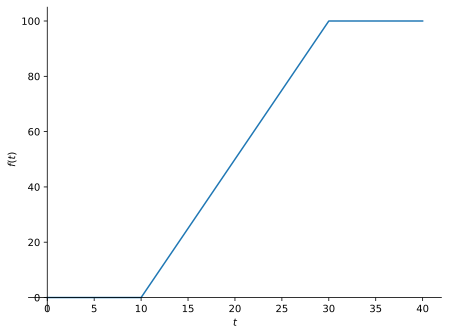

In [94]:
from matplotlib import pyplot as plt

# better plots in jupyter
%config InlineBackend.figure_formats = ['svg']

sp.plot(x, (t, 0, 40))
plt.show()

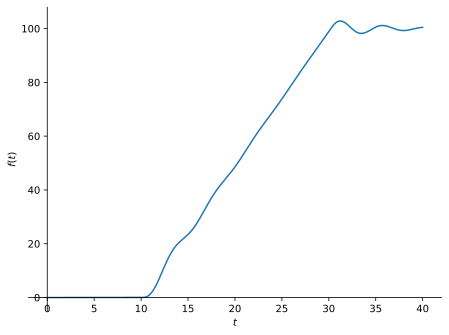

In [95]:
X = sp.laplace_transform(x, t, s, noconds=True)
Y = H * X
y = sp.inverse_laplace_transform(Y, s, t)

sp.plot(y, (t, 0, 40))
plt.show()

#### Rendre une expression `sympy` compatible avec `numpy`

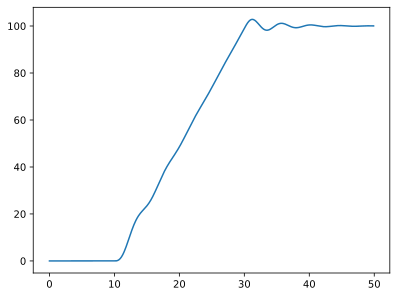

In [96]:
y_fun = sp.lambdify(t, y, "numpy")
t = np.arange(0, 50, 0.1)
y = y_fun(t)

plt.plot(t, y)
plt.show()

#### avec le package `control`

On travaille directement avec des array `numpy`

In [97]:
# Avec control pour un des fonctions plus spécialisées
import control as ct

s = ct.tf('s')

H = 2 / (s**2 + 0.4*s + 2)
print(H)

<TransferFunction>: sys[127]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

         2
  ---------------
  s^2 + 0.4 s + 2


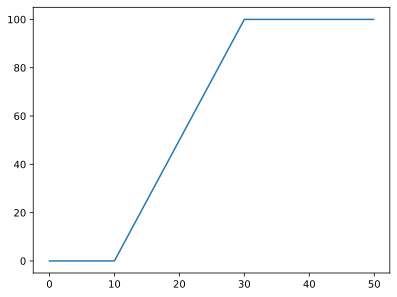

In [98]:
import numpy as np

t = np.arange(0, 50, 0.1)

x = 5 * t - 50
x[t < 10] = 0
x[t >= 30] = 5 * 30 - 50

plt.plot(t, x)
plt.show()

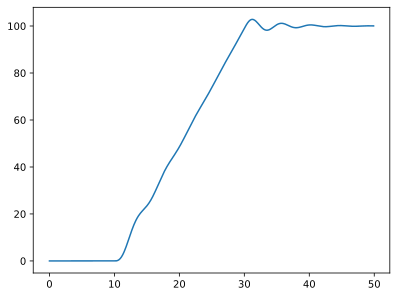

In [99]:
_, y = ct.forced_response(H, t, x)

plt.plot(t, y)
plt.show()

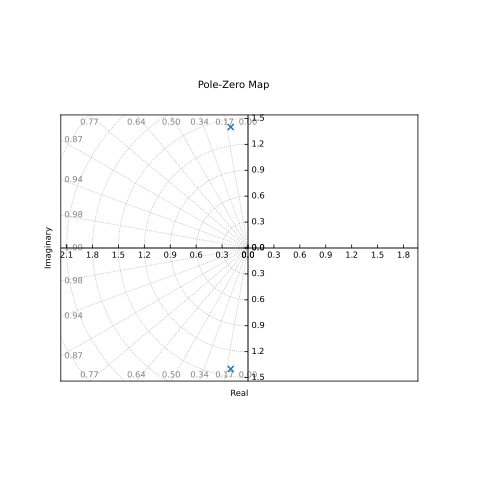

In [100]:
ct.pzmap(H, grid=True, title="Pole-Zero Map")
plt.show()

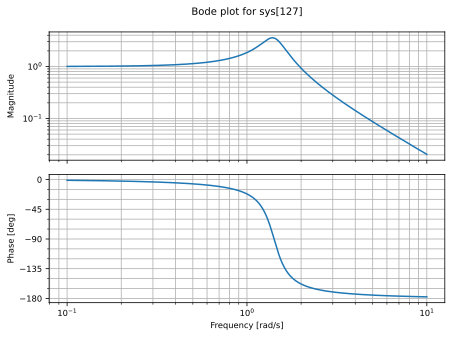

In [101]:
ct.bode(H)
plt.show()

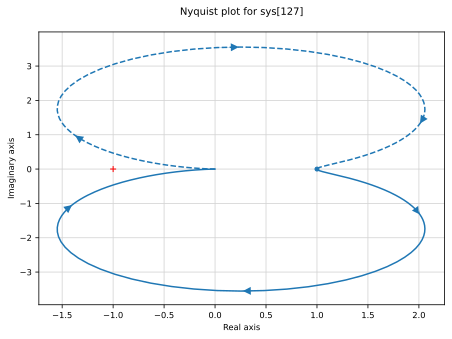

In [102]:
ct.nyquist(H) # diagram of the gain versus the phase (where the frequency does not appear)
plt.show()

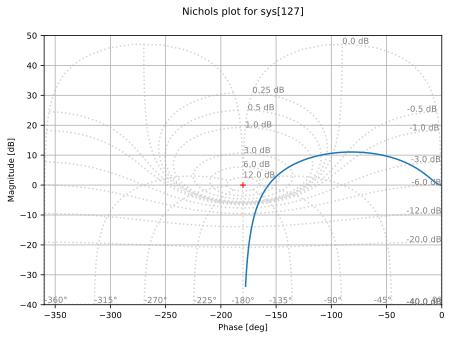

In [103]:
ct.nichols(H)
plt.grid()
plt.show()

#### Problème avec `control`: impossible de représenter un vrai temps-mort

Fonction de transfert avec temps-mort: $$e^{-sT_m} H(s)$$

Pas de problème avec `sympy`:

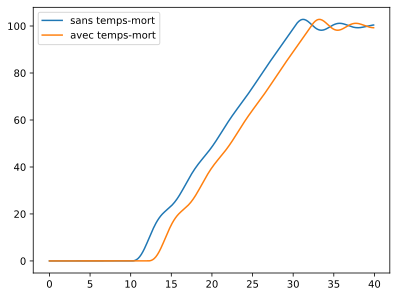

In [104]:
s, t = sp.symbols('s, t')

H = 2 / (s**2 + 0.4*s + 2)

Tm = 2
Htm = sp.exp(-s*Tm) * H

x = sp.Piecewise(
    (0, t <= 10),
    (5 * t - 50, (t > 10) & (t < 30)),
    (5 * 30 - 50, t >= 30)
)

X = sp.laplace_transform(x, t, s, noconds=True)
Ytm = Htm * X
ytm = sp.inverse_laplace_transform(Ytm, s, t)

Y = H * X
y = sp.inverse_laplace_transform(Y, s, t)

_t = np.arange(0, 40, 0.1)

plt.plot(_t, sp.lambdify(t, y, "numpy")(_t), label="sans temps-mort")
plt.plot(_t, sp.lambdify(t, ytm, "numpy")(_t), label="avec temps-mort")
plt.legend()
plt.show()

#### Temps-mort avec `control`

Le module `control` n'a pas de fonction `exp` et celle de `numpy` ne fonctionne pas:

In [105]:
s = ct.tf('s')

H = 2 / (s**2 + 0.4*s + 2)

# Htm = np.exp(-s*Tm) * H         # provoque une erreur

Nous sommes obligés de travailler avec une approximation polynomiale:

In [106]:
num, den = ct.pade(Tm, 5) # 5th-order Padé approximation
dead_time = ct.tf(num, den)

Htm = dead_time * H
print(Htm)

<TransferFunction>: sys[146]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

            -2 s^5 + 30 s^4 - 210 s^3 + 840 s^2 - 1890 s + 1890
  ------------------------------------------------------------------------
  s^7 + 15.4 s^6 + 113 s^5 + 492 s^4 + 1323 s^3 + 2163 s^2 + 2268 s + 1890


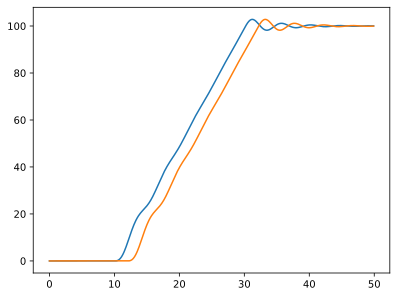

In [107]:
t = np.arange(0, 50, 0.1)

x = 5 * t - 50
x[t < 10] = 0
x[t >= 30] = 5 * 30 - 50

plt.plot(t, ct.forced_response(H, t, x)[1])
plt.plot(t, ct.forced_response(Htm, t, x)[1])
plt.show()

Attention aux zeros et pôles:

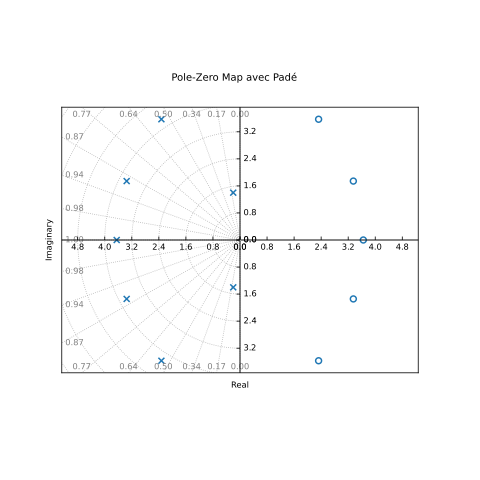

In [108]:
ct.pzmap(Htm, grid=True, title="Pole-Zero Map avec Padé")
plt.show()

#### Comment ajuster un modèle ?

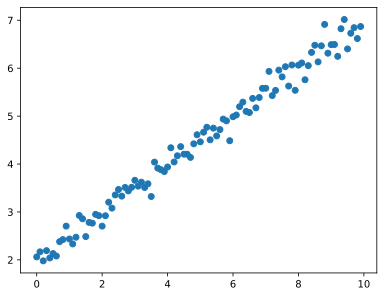

In [109]:
t = np.arange(0, 10, 0.1)
noise = np.random.randn(len(t)) * 0.2
x = (0.5*t + 2) + noise

plt.scatter(t, x)
plt.show()

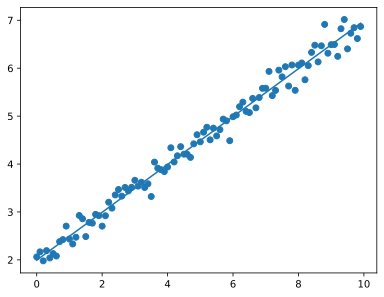

m = 0.4993642476386938
p = 1.9946557026146898


In [113]:
# Le modèle à ajuster. c-a-d trouver m et p qui font que le modèle colle le mieux aux donnée
def model(m, p, t):
    return m*t + p

# distance entre le modèle et les données. Il faut la minimiser
def cost(params):
    return np.linalg.norm(model(params[0], params[1], t) - x)

from scipy.optimize import minimize

res = minimize(cost, [0, 0], method='Nelder-Mead')
m, p = res.x

plt.scatter(t, x)
plt.plot(t, m*t + p)
plt.show()
print("m =", m)
print("p =", p)